In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Let's predict NBA salary by player performance and player popularity!

- Step 1: Aggregate player stats, popularity and salary
- Step 2: Investigate dataset
- Step 3: Modeling

## Aggreate data

#### Load player salary data.

In [2]:
# Load salary data for different seasons and combine them into a singel dataframe.
salary_dfs = []
for year in range(2000, 2022):
    partial_salary_df = pd.read_csv("../data/raw_data/player_salaries_" + str(year) + ".csv")
    partial_salary_df['Year'] = [year] * len(partial_salary_df)
    salary_dfs.append(partial_salary_df)
salary_df = pd.concat(salary_dfs)

salary_df['Salary'] = [int(s.strip('$').replace(',', '')) for s in salary_df['Salary']]
salary_df['Adjusted'] = [int(s.strip('$').replace(',', '')) for s in salary_df['Adjusted']]

#### Load salary cap to calculate salary/cap

It is hard to predict absolute salary because of mutliple reasons (inflation, internationalization of the NBA, team budgets...). As a result, a player with similar performance won't be paid as much 10 years ago in terms of dollar value. But the league enforces salary cap each year to restrict the total salary a team can pay. So we can get relative salary data = salary/salary_cap or salary/team_total_salary.

In [4]:
# Load and merge salary cap
salary_cap_df = pd.read_csv("../data/raw_data/salary_caps.csv")

In [5]:
# Combine dfs.
year_to_cap_dict = dict()
for index, row in salary_cap_df.iterrows():
    year_to_cap_dict[row['Year']] = row['Salary Cap']
salary_df["SalaryCap"] = [year_to_cap_dict[year] for year in salary_df['Year']]

salary_df['SalaryCap'] = [int(s.strip('$').replace(',', '')) for s in salary_df['SalaryCap']]

In [6]:
# Get relative salary as salary/salary_cap
relative_salaries = []
for index, row in salary_df.iterrows():
    salary = row['Salary']
    cap = row['SalaryCap']
    relative_salaries.append(salary/cap)
salary_df["Salary/Cap"] = relative_salaries

#### Load team salary and calculate salary/team_salary

In [9]:
# Load team salaries.
team_salary_dfs = []
for year in range(2000, 2022):
    partial_team_salary_df = pd.read_csv("../data/raw_data/team_salaries_" + str(year) + ".csv")
    partial_team_salary_df['Year'] = [year] * len(partial_team_salary_df)
    team_salary_dfs.append(partial_team_salary_df)
team_salary_df = pd.concat(team_salary_dfs)

In [10]:
# Load player stats data to see which team each player plays in.
player_stat_dfs = []
for year in range(2000, 2022):
    partial_player_stat_df = pd.read_csv("../data/raw_data/player_stats_" + str(year) + ".csv")
    partial_player_stat_df['Year'] = [year] * len(partial_player_stat_df)
    player_stat_dfs.append(partial_player_stat_df)
player_stat_df = pd.concat(player_stat_dfs)

# There are '*' symbols in player names, let's remove them.
player_stat_df['Player'] = [player.strip('*') for player in player_stat_df['Player']]

In [11]:
# Get mapping between full name and abbreviation
full_names = sorted(list(set(team_salary_df['Team'].tolist())))
abbr_names = sorted(list(set(player_stat_df['Tm'].tolist())))

# NBA team changes overtie, let's conpensate for that.
indices = [4,6,20,22,23,32,34,36]
names = ['Charlotte', 'Charlotte', 'Brooklyn', 'New Orleans', 'New Orleans', 'Oklahoma City', 'Total', 'Memphis']
for i, n in zip(indices, names):
    full_names.insert(i, n)

abbr_to_full_dict = dict(zip(abbr_names, full_names))

In [12]:
# Get team salary.
team_salaries = []
for _, row in salary_df.iterrows():
    year = row['Year']
    player = row['Player']
    # Find the team name abbreviation for all the teams a player played for.
    team_abbrs = player_stat_df[(player_stat_df['Player'] == player) & (player_stat_df['Year'] == year)]['Tm'].tolist()
    # Get the corresponding full team names.
    team_fulls = [abbr_to_full_dict[tm] for tm in team_abbrs]
    # Get team total salary for all the teams a player played for.
    all_team_salaries = team_salary_df[(team_salary_df['Year'] == year) & (team_salary_df['Team'].isin(team_fulls))]['Salary'].tolist()
    all_team_salaries = [int(s.strip('$').replace(',', '')) for s in all_team_salaries]
    # Set team salary to None, if teams can't be found
    if len(all_team_salaries) == 0:
        team_salary = None
    else:
        team_salary = sum(all_team_salaries) / len(all_team_salaries)
    team_salaries.append(team_salary)
salary_df['TeamSalary'] = team_salaries

In [13]:
# Get relative salary as salary/salary_cap
relative_salaries = []
for index, row in salary_df.iterrows():
    salary = row['Salary']
    team_salary = row['TeamSalary']
    if team_salary:
        relative_salaries.append(salary/team_salary)
    else:
        relative_salaries.append(None)
salary_df["Salary/TeamSalary"] = relative_salaries

Notice there are some players without a team salary, these players doesn't exists in the *player_stat_df*.

#### Add player search result number and player search trend and to player_stat_df

Note that we will put player popularity in player_stat_df.

In [111]:
# Load player search trend
search_df = pd.read_csv("../data/clean_data/player_search_trend.csv")

In [112]:
player_num_search = []
players = player_stat_df["Player"]
years = player_stat_df["Year"]
for player, year in zip(players, years):
    num_search = search_df[(search_df["Player"] == player) & (search_df["Year"] == year)] \
        ["Google Search Trend"].tolist()
    if not num_search:
        player_num_search.append(0)
    else:
        player_num_search.append(num_search[0])
player_stat_df["SearchTrend"] = player_num_search

#### Add per mintue stat as efficiency

How should we define player performance? The idea is that if two players play under exactly the same circumstances, the player with better performance should bring proportional benefits/advantages to the team. The field goal percentage, for example, is the the number of made shot devided by the number of tries. If two players are allowed N tries, the one with higher field goal percentage should make more shots.

However, most of stats we have are per game stats. If player who plays 30 minutes per game scores the same as another player who plays 10 minutes per game, we can argue that the second player performs better. This game time (minutes played per game) is controlled by the coach instead of the player, which should not be used in discussing a player's performance. So instead of using per game stats, let's construct and play with per minute stats. This is the estimation of how efficient a player is on the court.

Text(0.5, 1.0, 'Rebounds Per Game vs. Minutes Per Game')

<Figure size 1152x648 with 0 Axes>

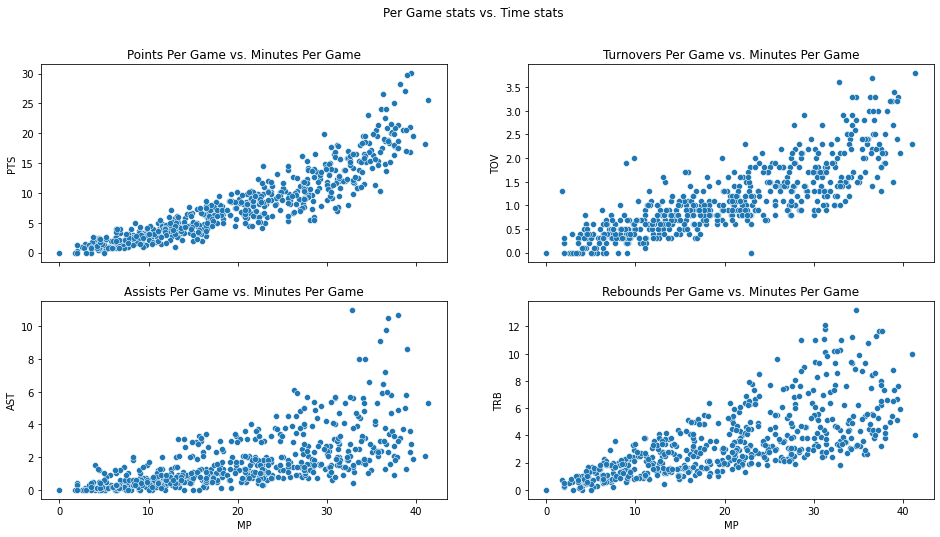

In [340]:
player_stat_2010_df = player_stat_df[player_stat_df["Year"] == 2010]
%matplotlib inline
plt.figure(figsize=(16,9))
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,8))
fig.suptitle('Per Game stats vs. Time stats')

sns.scatterplot(ax = axes[0,0], y = player_stat_2010_df["PTS"], x = player_stat_2010_df["MP"]) \
    .set_title("Points Per Game vs. Minutes Per Game")
sns.scatterplot(ax = axes[0,1],y = player_stat_2010_df["TOV"], x = player_stat_2010_df["MP"]) \
    .set_title("Turnovers Per Game vs. Minutes Per Game")
sns.scatterplot(ax = axes[1,0],y = player_stat_2010_df["AST"], x = player_stat_2010_df["MP"]) \
    .set_title("Assists Per Game vs. Minutes Per Game")
sns.scatterplot(ax = axes[1,1],y = player_stat_2010_df["TRB"], x = player_stat_2010_df["MP"]) \
    .set_title("Rebounds Per Game vs. Minutes Per Game")

As we can see from the plot above, how much time a player plays each game has a positive (almost linear) relation to most of the important player per game stats.

In [136]:
# Load team stats
team_stat_dfs = []
for year in range(2000,2022):
    partial_team_stat_df = pd.read_csv("../data/raw_data/team_stats_" + str(year) + ".csv")
    partial_team_stat_df["Year"] = [year] * len(partial_team_stat_df)
    team_stat_dfs.append(partial_team_stat_df)
team_stat_df = pd.concat(team_stat_dfs)
team_stat_df['Team'] = [team.strip('*') for team in team_stat_df['Team']]

In [138]:
per_game_stats = ["FG", "3P", "2P", "FT", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", 
                  "PF", "PTS"]
for stat in per_game_stats:
    player_stat_df[stat+"_per_min"] = player_stat_df[stat] / player_stat_df["MP"]
    team_stat_df[stat+"_per_min"] = team_stat_df[stat] / team_stat_df["MP"]

Let's see if this make sense.

In [240]:
player_stat_df[(player_stat_df["FG_per_min"]>0.295) &
              (player_stat_df["MP"] > 30)]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT_team,ORB_team,DRB_team,TRB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team
336,Shaquille O'Neal,C,27,LAL,79,79,40.0,12.1,21.1,0.574,...,20.1,13.6,33.4,47.0,23.4,7.5,6.5,13.9,22.5,100.8
80,Kobe Bryant,SG,27,LAL,80,80,41.0,12.2,27.2,0.450,...,19.7,11.8,30.3,42.2,21.1,7.7,4.3,13.9,23.1,99.4
116,Stephen Curry,PG,27,GSW,79,79,34.2,10.2,20.2,0.504,...,16.7,10.0,36.2,46.2,28.9,8.4,6.1,15.2,20.7,114.9
19,Giannis Antetokounmpo,PF,24,MIL,72,72,32.8,10.0,17.3,0.578,...,17.9,9.3,40.4,49.7,26.0,7.5,5.9,13.9,19.6,118.1
12,Giannis Antetokounmpo,PF,25,MIL,63,63,30.4,10.9,19.7,0.553,...,18.3,9.5,42.2,51.7,25.9,7.2,5.9,15.1,19.6,118.7
308,Kyrie Irving,PG,27,BRK,20,20,32.9,10.0,20.8,0.478,...,17.9,10.6,37.3,47.9,24.5,6.4,4.5,15.3,21.0,111.8
623,Russell Westbrook,PG,31,HOU,57,57,35.9,10.6,22.5,0.472,...,20.6,9.8,34.5,44.3,21.6,8.7,5.2,14.7,21.8,117.8
17,Giannis Antetokounmpo,PF,26,MIL,61,61,33.0,10.3,18.0,0.569,...,16.2,10.3,37.8,48.1,25.5,8.1,4.6,13.8,17.3,120.1
45,Bradley Beal,SG,27,WAS,60,60,35.8,11.2,23.0,0.485,...,20.1,9.7,35.5,45.2,25.5,7.3,4.1,14.4,21.6,116.6
151,Stephen Curry,PG,32,GSW,63,63,34.2,10.4,21.7,0.482,...,16.6,8.0,35.1,43.0,27.7,8.2,4.8,15.0,21.2,113.7


Yes, these are the most efficient scorers to have ever played the game.

Text(0.5, 1.0, 'Rebounds Per Minute vs. Minutes Per Game')

<Figure size 1152x648 with 0 Axes>

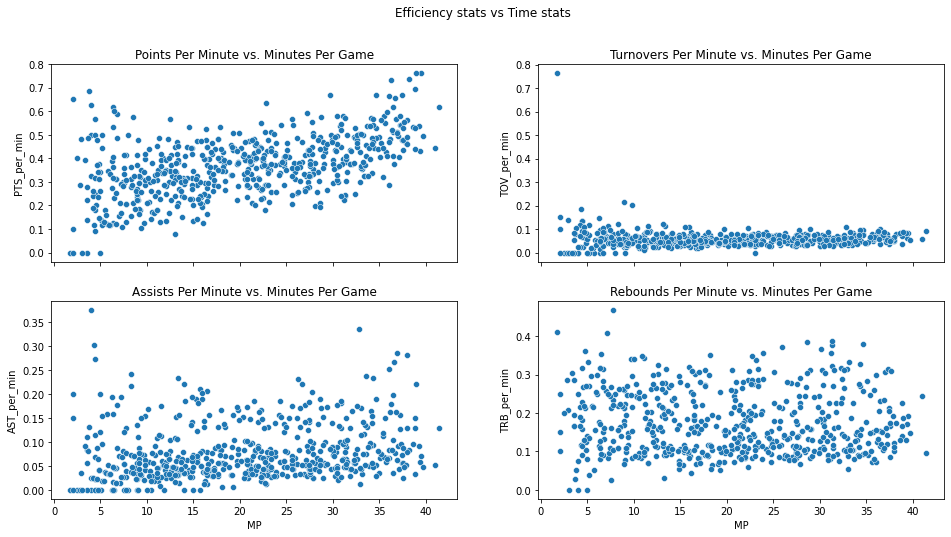

In [341]:
player_stat_2010_df = player_stat_df[player_stat_df["Year"] == 2010]
%matplotlib inline
plt.figure(figsize=(16,9))
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,8))
fig.suptitle('Efficiency stats vs Time stats')

sns.scatterplot(ax = axes[0,0], y = player_stat_2010_df["PTS_per_min"], x = player_stat_2010_df["MP"]) \
    .set_title("Points Per Minute vs. Minutes Per Game")
sns.scatterplot(ax = axes[0,1],y = player_stat_2010_df["TOV_per_min"], x = player_stat_2010_df["MP"]) \
    .set_title("Turnovers Per Minute vs. Minutes Per Game")
sns.scatterplot(ax = axes[1,0],y = player_stat_2010_df["AST_per_min"], x = player_stat_2010_df["MP"]) \
    .set_title("Assists Per Minute vs. Minutes Per Game")
sns.scatterplot(ax = axes[1,1],y = player_stat_2010_df["TRB_per_min"], x = player_stat_2010_df["MP"]) \
    .set_title("Rebounds Per Minute vs. Minutes Per Game")

Nice! As we can see, only positive stats like points per minute and assists per minute now as weak positive relation with minutes per game. This make sense because the better a player perform, the longer he will stay in the game.

#### Combine player stats and team stats to measure contribution

Text(0.5, 1.0, 'Avg Points Per Minute for Each Team')

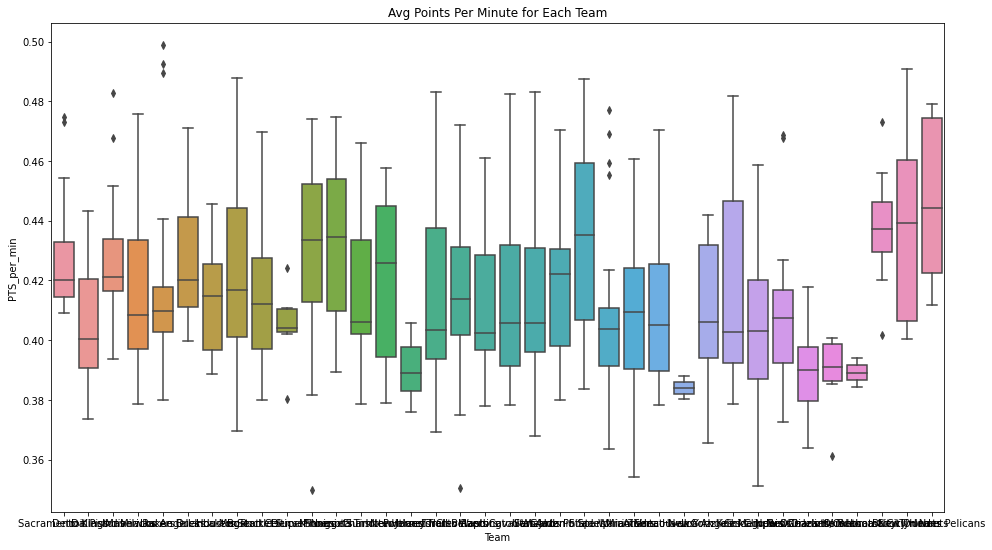

In [152]:
%matplotlib inline
plt.figure(figsize=(16,9))
sns.boxplot(y = team_stat_df["PTS_per_min"], x = team_stat_df["Team"]) \
    .set_title("Avg Points Per Minute for Each Team")

Similarly, even after adjusting for total minutes played, team stats varies. A top defencing team won't score as much as the top scoring team, but can also be successfull. Let's define relative performance by player_stat_per_per_min/team_stat_per_min and player_stat_per_per_min/team_stat_per_min. This is the stats that measures a player's contribution to the team.

In [53]:
# Get the mapping from abbreviation to full name for each year
year_to_mapping = dict()
for year in range(2000, 2022):
    team_names = list(set(team_stat_df[team_stat_df['Year'] == year]["Team"].tolist()))
    tm_names = list(set(player_stat_df[player_stat_df['Year'] == year]["Tm"].tolist()))
    tm_names.remove("TOT")
    assert(len(team_names) == len(tm_names))
    year_to_mapping[year] = dict(zip(sorted(tm_names), sorted(team_names)))

In [208]:
per_game_stats = ["FG", "3P", "2P", "FT", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", 
                  "PF", "PTS"]
per_min_stats = [s + "_per_min" for s in per_game_stats]
players = player_stat_df["Player"]
years = player_stat_df["Year"]
teams = player_stat_df["Tm"]
# Add per min contribution
for stat_key in per_min_stats:
    stat_list = []
    for player, year, tm in zip(players, years, teams):
        if tm == "TOT":
            stat_list.append(None)
            continue
        team = year_to_mapping[year][tm]
        stat_val = team_stat_df[(team_stat_df["Team"] == team) & 
                                (team_stat_df["Year"] == year)][stat_key].tolist()[0]
        if not stat_val:
            stat_list.append(None)
        else:
            stat_list.append(stat_val)
    player_stat_df[stat_key + "_team"] = stat_list
    player_stat_df[stat_key + "/team"] = player_stat_df[stat_key] / player_stat_df[stat_key + "_team"]
    

In [209]:
# Add per game contribution
for stat_key in per_game_stats:
    stat_list = []
    for player, year, tm in zip(players, years, teams):
        if tm == "TOT":
            stat_list.append(None)
            continue
        team = year_to_mapping[year][tm]
        stat_val = team_stat_df[(team_stat_df["Team"] == team) & 
                                (team_stat_df["Year"] == year)][stat_key].tolist()[0]
        if not stat_val:
            stat_list.append(None)
        else:
            stat_list.append(stat_val)
    player_stat_df[stat_key + "_team"] = stat_list
    player_stat_df[stat_key + "/team"] = player_stat_df[stat_key] / player_stat_df[stat_key + "_team"]

Now let's see if this make sense. Let's choose the players that contribute more to the team. Let choose players who are at least 1.8 times more efficient in scoring compared to the team average.

In [230]:
player_stat_df[(player_stat_df["FG_per_min/team"]>1.83) &
              (player_stat_df["MP"] > 30)]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT_team,ORB_team,DRB_team,TRB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team
336,Shaquille O'Neal,C,27,LAL,79,79,40.0,12.1,21.1,0.574,...,20.1,13.6,33.4,47.0,23.4,7.5,6.5,13.9,22.5,100.8
336,Shaquille O'Neal,C,29,LAL,67,66,36.1,10.6,18.3,0.579,...,18.2,12.5,31.8,44.3,23.0,7.6,5.8,12.7,22.2,101.3
280,Tracy McGrady,SG,23,ORL,75,74,39.4,11.1,24.2,0.457,...,19.7,11.7,29.2,40.9,20.4,8.5,3.7,14.4,23.0,98.5
103,Vince Carter,SF,28,NJN,57,56,38.9,10.0,21.7,0.462,...,19.0,10.4,29.1,39.5,21.6,7.9,3.8,14.2,24.2,91.4
385,Jermaine O'Neal,PF,26,IND,44,41,34.8,8.8,19.4,0.452,...,21.3,10.6,29.5,40.1,18.2,7.5,4.4,14.3,23.0,93.0
80,Kobe Bryant,SG,27,LAL,80,80,41.0,12.2,27.2,0.450,...,19.7,11.8,30.3,42.2,21.1,7.7,4.3,13.9,23.1,99.4
538,Dwyane Wade,SG,27,MIA,79,79,38.6,10.8,22.0,0.491,...,17.2,10.1,29.4,39.5,20.4,7.9,5.5,12.5,20.7,98.3
301,Al Jefferson,C,29,CHA,73,73,35.0,9.6,18.8,0.509,...,18.0,9.5,33.2,42.7,21.7,6.1,5.1,12.3,18.2,96.9
12,Giannis Antetokounmpo,PF,25,MIL,63,63,30.4,10.9,19.7,0.553,...,18.3,9.5,42.2,51.7,25.9,7.2,5.9,15.1,19.6,118.7


Wow! These are the most dominant players to have ever played in the league. Let's check the per
game stat, let's choose the players that contribute at least 30 percent of the total score each game.

In [227]:
player_stat_df[(player_stat_df["FG/team"]>0.3) &
              (player_stat_df["MP"] > 30)]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT_team,ORB_team,DRB_team,TRB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team
336,Shaquille O'Neal,C,27,LAL,79,79,40.0,12.1,21.1,0.574,...,20.1,13.6,33.4,47.0,23.4,7.5,6.5,13.9,22.5,100.8
219,Allen Iverson,SG,25,PHI,71,71,42.0,10.7,25.5,0.420,...,20.7,13.1,31.7,44.8,20.6,8.4,5.0,15.8,20.4,94.7
216,Allen Iverson,SG,26,PHI,60,59,43.7,11.1,27.8,0.398,...,20.0,13.3,30.9,44.2,20.0,8.6,4.4,15.3,20.1,91.0
280,Tracy McGrady,SG,23,ORL,75,74,39.4,11.1,24.2,0.457,...,19.7,11.7,29.2,40.9,20.4,8.5,3.7,14.4,23.0,98.5
80,Kobe Bryant,SG,27,LAL,80,80,41.0,12.2,27.2,0.450,...,19.7,11.8,30.3,42.2,21.1,7.7,4.3,13.9,23.1,99.4
242,Allen Iverson,PG,30,PHI,72,72,43.1,11.3,25.3,0.447,...,21.6,10.6,29.6,40.2,20.2,7.9,4.9,14.1,20.9,99.4
256,LeBron James,SF,21,CLE,79,79,42.5,11.1,23.1,0.480,...,20.6,11.7,30.6,42.3,19.0,6.9,4.8,13.9,21.1,97.6


We can see that LeBron James and Allen Iverson are both players with high total contribution, but not very high efficiency.

In [232]:
player_stat_df.to_csv("../data/clean_data/player_stats_full.csv")
salary_df.to_csv("../data/clean_data/player_salary_full.csv")

**One thing to note about contribution and efficiency data is that if a player's average minute on court is very low, these stats can be very misleading. We should remove these players,**

#### Add player salary

How should we aggregate player salary? If a player plays really well, his salary does not go up instantly because he is still in a contract. We should consider that there is a delay in when a player plays well and when his salary goes up. Let's try both no delay and 2-year delay.

In [314]:
salarys = ["Salary", "Adjusted", "Salary/Cap", "Salary/TeamSalary"]
players = player_stat_df["Player"]
years = player_stat_df["Year"]

data_df = player_stat_df.copy(deep=True)
for salary_key in salarys:
    sals = []
    for player, year in zip(players, years):
        salary_val = salary_df[(salary_df["Player"] == player) & 
                                (salary_df["Year"] == year)][salary_key].tolist()
        if not salary_val:
            sals.append(None)
        else:
            sals.append(salary_val[0])
    data_df[salary_key] = sals

In [316]:
salarys = ["Salary", "Adjusted", "Salary/Cap", "Salary/TeamSalary"]
for salary_key in salarys:
    sals = []
    for player, year in zip(players, years):
        salary_val = salary_df[(salary_df["Player"] == player) & 
                                (salary_df["Year"] == year+2)][salary_key].tolist()
        if not salary_val:
            sals.append(None)
        else:
            sals.append(salary_val[0])
    data_df[salary_key+"_delay"] = sals

In [317]:
data_df.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       ...
       'PF_team', 'PTS_team', 'Salary', 'Adjusted', 'Salary/Cap',
       'Salary/TeamSalary', 'Salary_delay', 'Adjusted_delay',
       'Salary/Cap_delay', 'Salary/TeamSalary_delay'],
      dtype='object', length=104)

In [318]:
data_df.to_csv("../data/clean_data/data.csv")

## Explore the data

In [328]:
good_stats = ["3P%", "2P%", "FT%", "eFG%"]
categorical_stats = ["Tm", "Pos"]
time_stats = ["MP", "G", "GS"]
per_game_stats = ["FG", "3P", "2P", "FT", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", 
                  "PF", "PTS"]
efficiency_stats = [s + "_per_min" for s in per_game_stats]
contribution_stats = [s + "/team" for s in per_game_stats]
efficiency_contribution_stats = [s + "/team" for s in efficiency_stats]
trend_stats = ["SearchTrend"]
salary_stats = ["Salary", "Adjusted", "Salary/Cap", "Salary/TeamSalary"]
salary_delay_stats = [s+"_delay" for s in salary_stats]

Let's see the correlations between per game stats and time stats.

<AxesSubplot:>

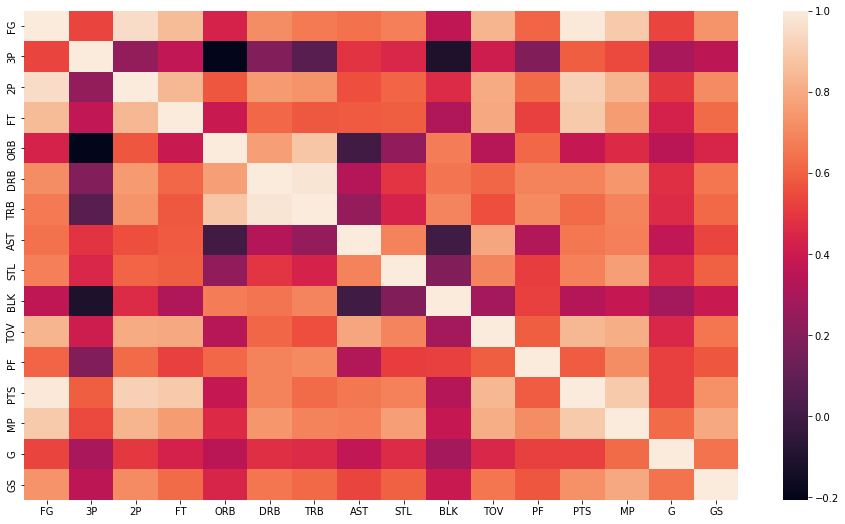

In [321]:
partial_df = data_df[per_game_stats + time_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

Let's first pay attention to the light colored squares (high correlation). As expected, **minutes played (MP)** has high correlation with many entries, thus we should be careful not to include this in our model training if we want to use per game stats.

**Points per game (PTS)** and **field goal per game (FT)** also have many correlations as it is a linear combination of **2 points per game (2P)** and **3 points per game (3P)**, let's remove them.

It is interesting to see that **turnovers per game (TOV)** (number of mistakes made per game) has high correlation with **points per game (PTS)**. I guess the better you are, the more you are likely to make mistakes.

In [279]:
per_game_stats.remove("PTS")
per_game_stats.remove("FG")
per_game_stats.remove("TRB")
efficiency_stats = [s + "_per_min" for s in per_game_stats]
contribution_stats = [s + "/team" for s in per_game_stats]
efficiency_contribution_stats = [s + "/team" for s in efficiency_stats]

Now let's look at the darker squares, **3 points per game (3P)** has a negative correlation to **offensive rebounds per game (ORB)** and **blocks per game (BLK)**. Good three point shooters can't defend well, as expected.

### Let's do the same with efficiency and contribution stats.

<AxesSubplot:>

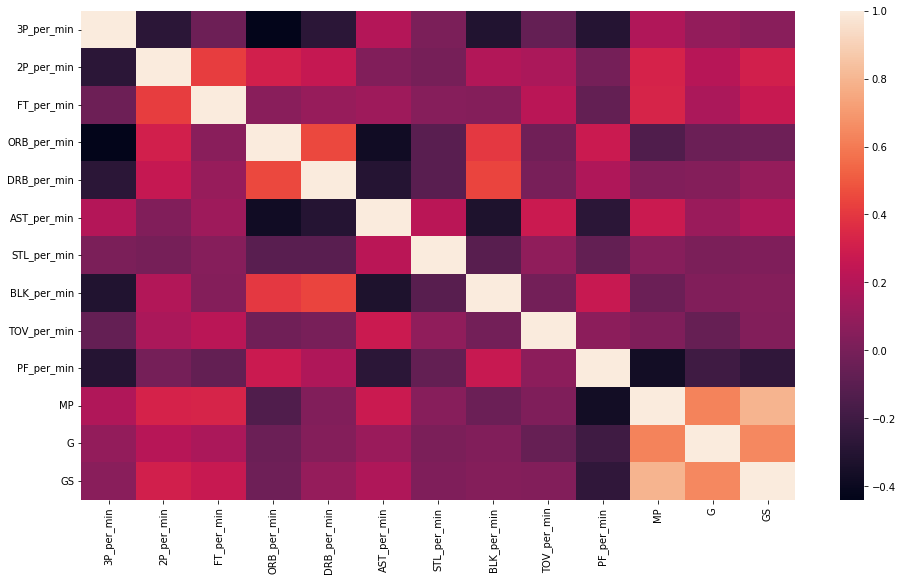

In [280]:
partial_df = data_df[efficiency_stats + time_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

<AxesSubplot:>

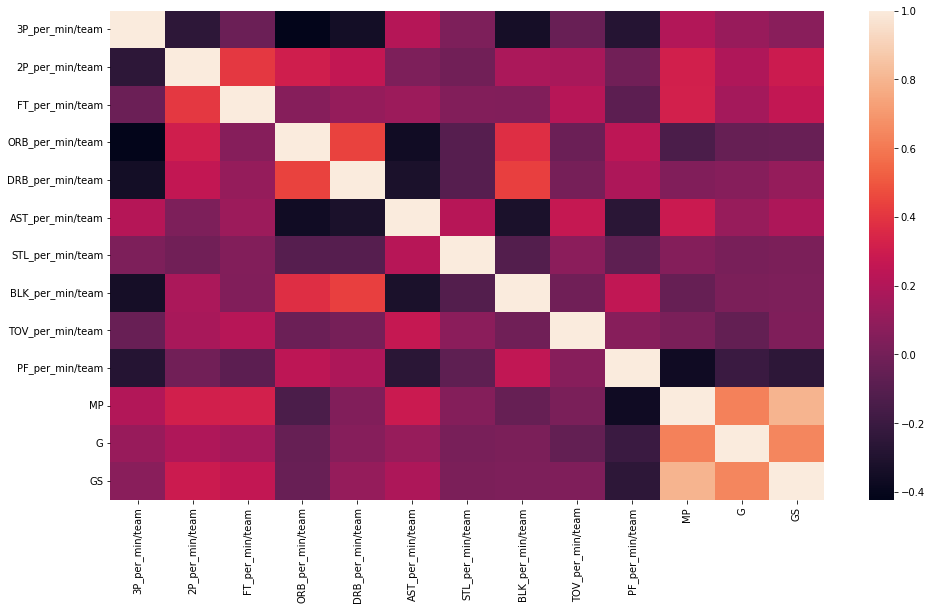

In [282]:
partial_df = data_df[efficiency_contribution_stats + time_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

### Beautiful! Now time stats only have high correlation within itself.

### Now let's take a look at the good stats and time stats.

<AxesSubplot:>

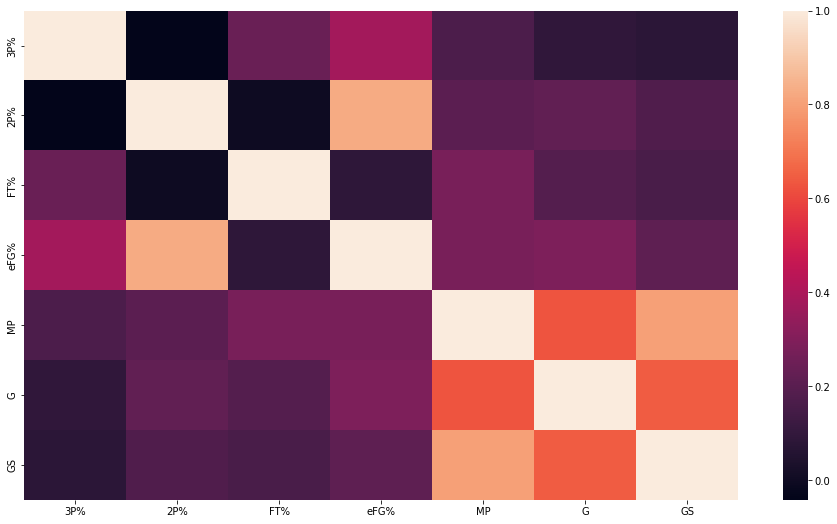

In [283]:
partial_df = data_df[good_stats + time_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

As expected, a good performance statistics should not depend on time statistics. Let's look at good stats and per game stats.

<AxesSubplot:>

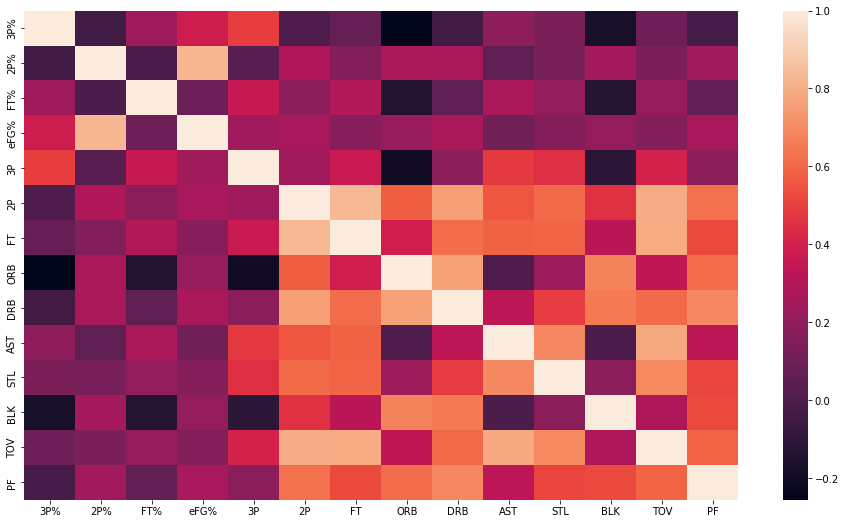

In [286]:
partial_df = data_df[good_stats + per_game_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

### That's why they were called the good stats. :P Let's look at good stats with efficiency and contribution.

<AxesSubplot:>

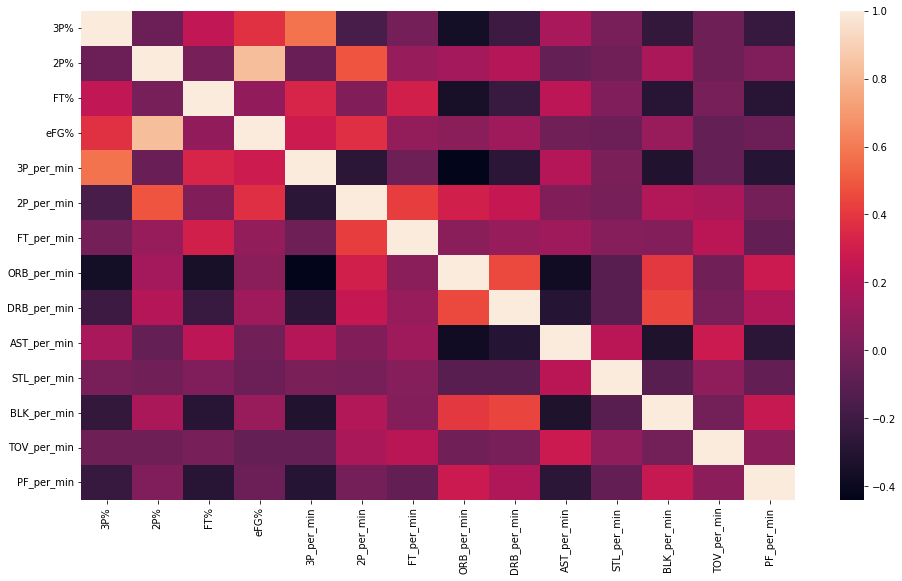

In [288]:
partial_df = data_df[good_stats + efficiency_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

<AxesSubplot:>

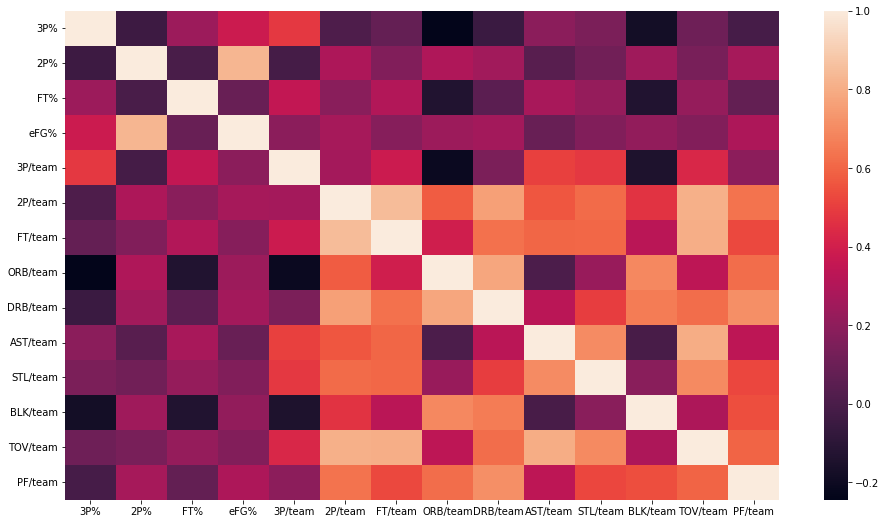

In [289]:
partial_df = data_df[good_stats + contribution_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

### Great! Good stats should be able to be used with any other stats. But what about per game sats, efficiency stats and contribution stats. Let's 

<AxesSubplot:>

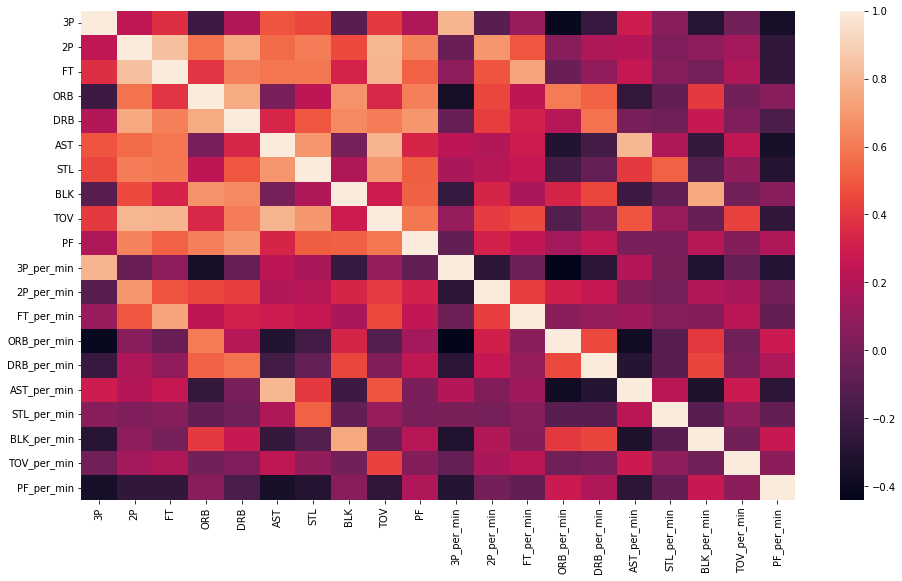

In [290]:
partial_df = data_df[per_game_stats + efficiency_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

<AxesSubplot:>

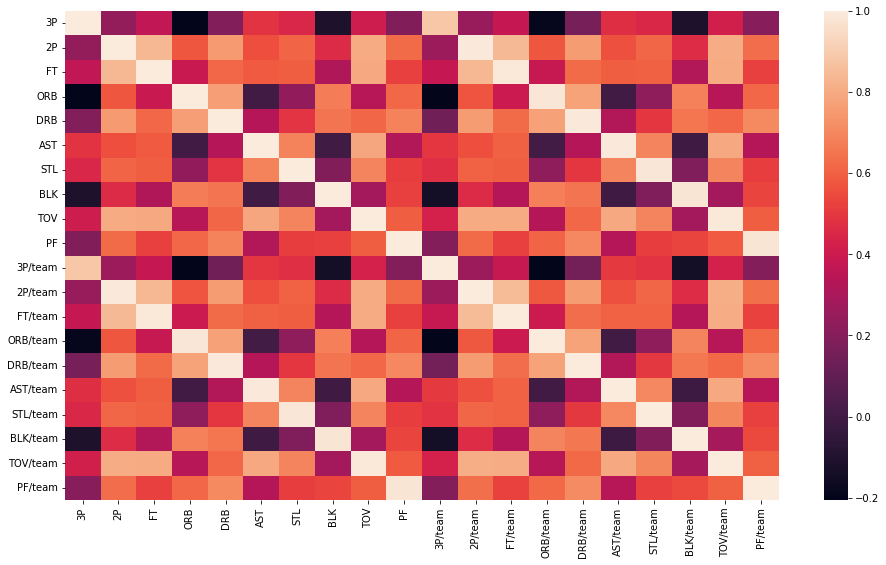

In [291]:
partial_df = data_df[per_game_stats + contribution_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

<AxesSubplot:>

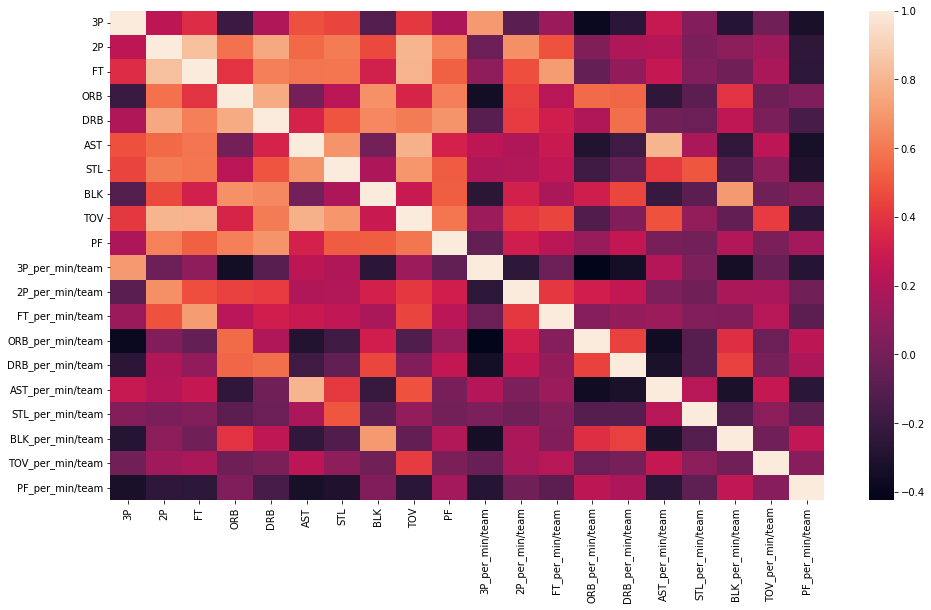

In [292]:
partial_df = data_df[per_game_stats + efficiency_contribution_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

<AxesSubplot:>

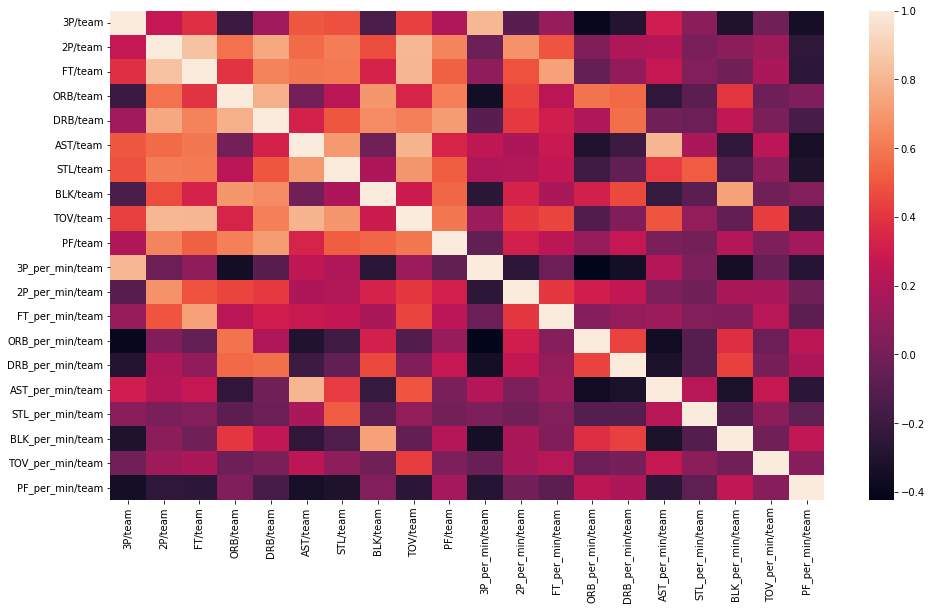

In [295]:
partial_df = data_df[contribution_stats + efficiency_contribution_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

<AxesSubplot:>

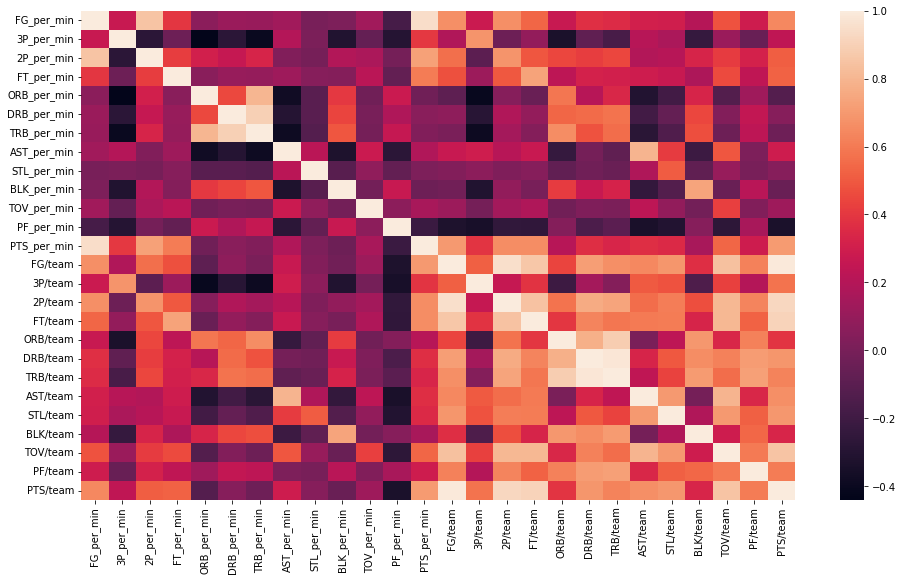

In [390]:
partial_df = data_df[efficiency_stats + contribution_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

### Now we see. Per game stats should not be used with contribution stats.

### What about salary? Let's see salary vs time stats.

<AxesSubplot:>

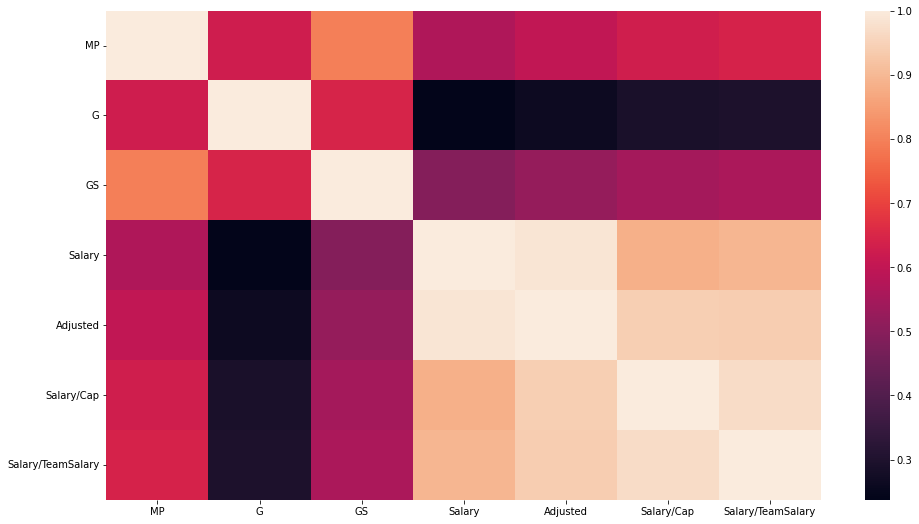

In [329]:
partial_df = data_df[time_stats + salary_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

### Interesting, how much a player play does not have a huge impact on his salary. Let's see per game/efficiency/contribution stats vs. salary. Let's exclude player who doesn't play much (less than 15 minutes per game), as they are very unstable in the efficiency and contribution stats.

<AxesSubplot:>

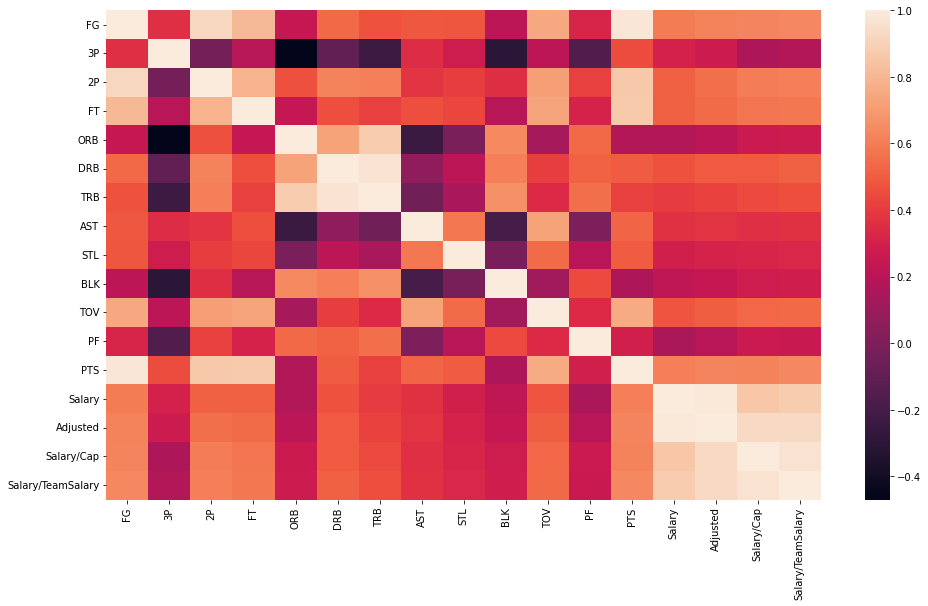

In [330]:
partial_df = data_df[data_df["MP"] > 15][per_game_stats + salary_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

<AxesSubplot:>

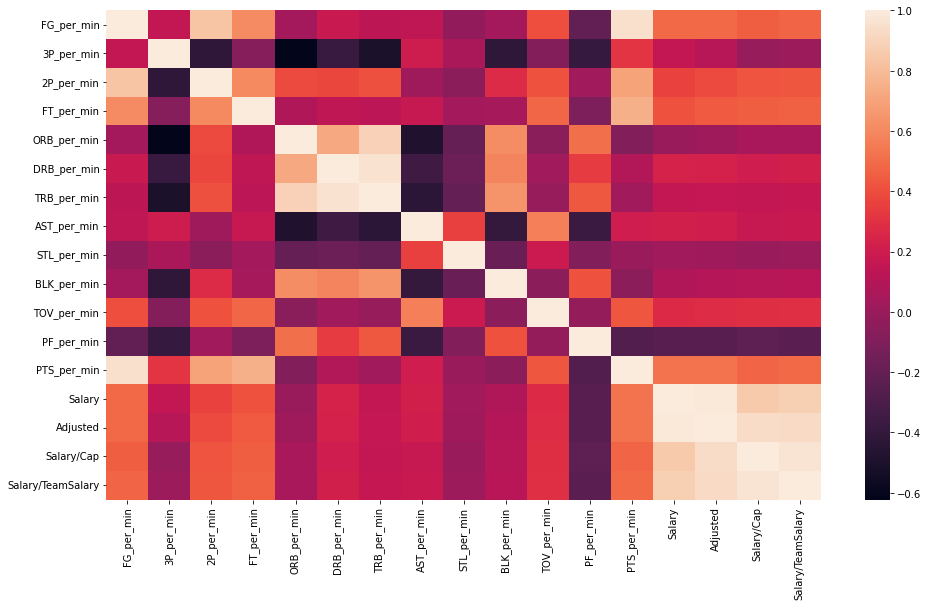

In [331]:
partial_df = data_df[data_df["MP"] > 15][efficiency_stats + salary_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

<AxesSubplot:>

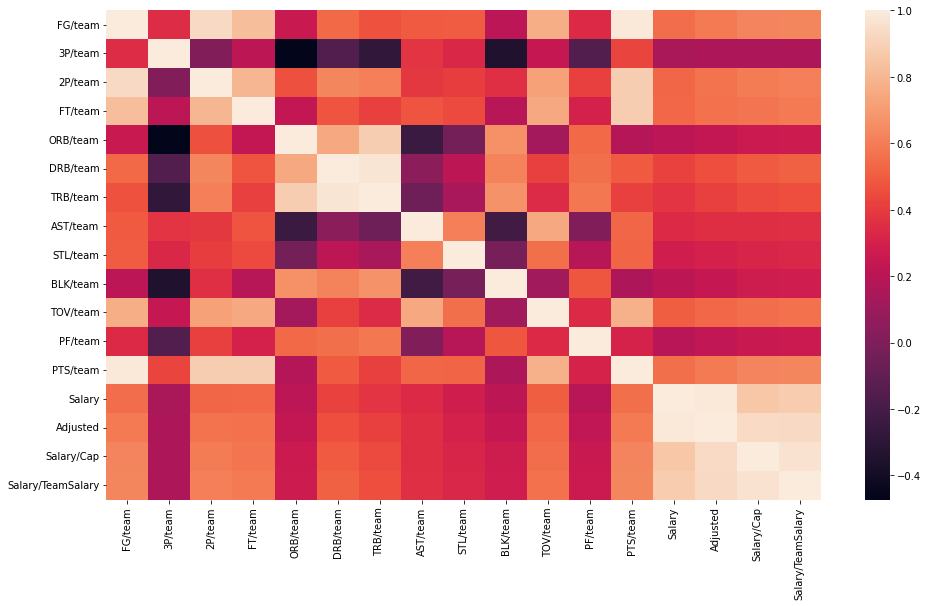

In [332]:
partial_df = data_df[data_df["MP"] > 15][contribution_stats + salary_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

### They all seems to have a positive relation with salary. Nice! Notice how salary/team_salary is even lighter than adjusted salary. **Salary/TeamSalary** is a better estimate to use if we want to use a simple linaer model.

### Let's see how the categorical variables affect salary.

Text(0.5, 1.0, 'Salary for Each Position')

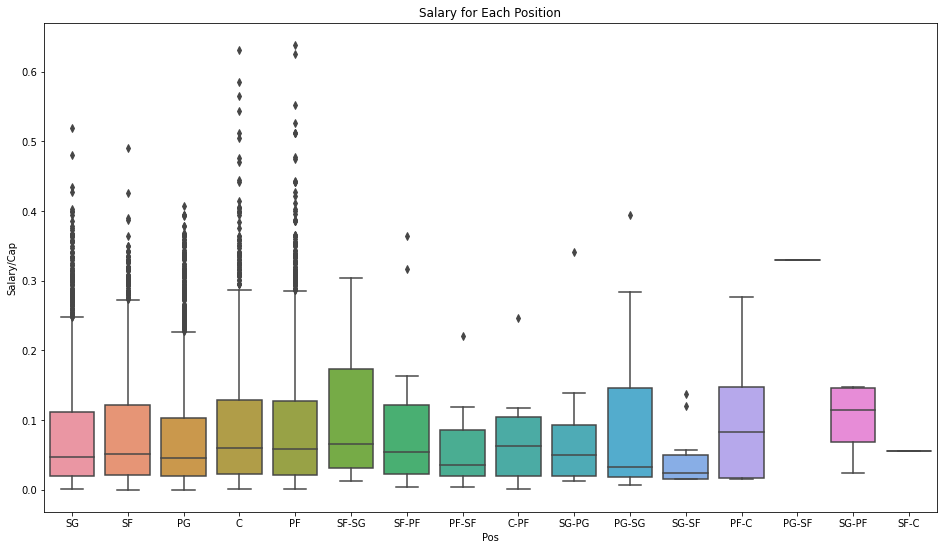

In [338]:
%matplotlib inline
plt.figure(figsize=(16,9))
sns.boxplot(y = data_df["Salary/Cap"], x = data_df["Pos"]) \
    .set_title("Salary for Each Position")

Text(0.5, 1.0, 'Salary for Each Team')

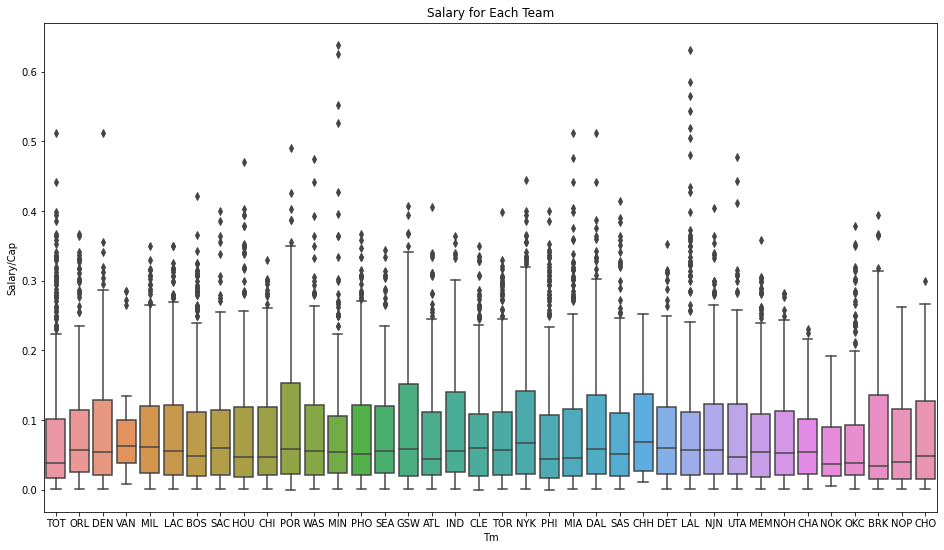

In [339]:
%matplotlib inline
plt.figure(figsize=(16,9))
sns.boxplot(y = data_df["Salary/Cap"], x = data_df["Tm"]) \
    .set_title("Salary for Each Team")

### At last, let's compared salary vs salary delayed.

<AxesSubplot:>

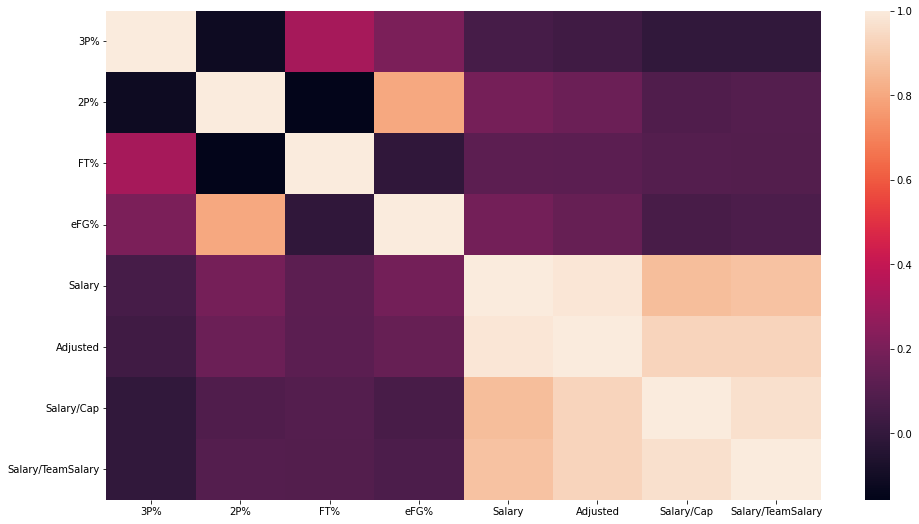

In [360]:
partial_df = data_df[data_df["MP"] > 15][good_stats + salary_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

<AxesSubplot:>

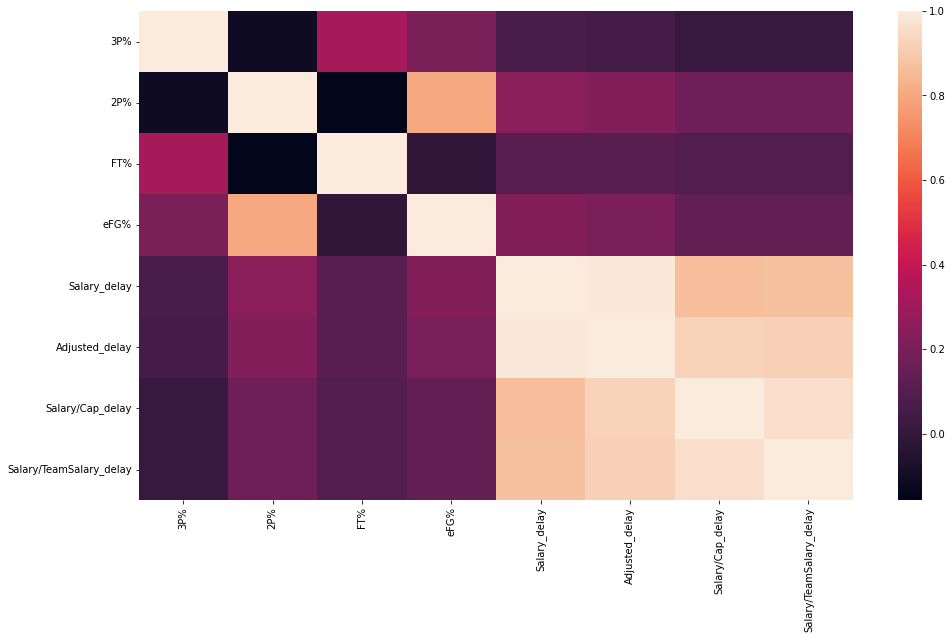

In [361]:
partial_df = data_df[data_df["MP"] > 15][good_stats + salary_delay_stats]
%matplotlib inline
plt.figure(figsize=(16,9))
sns.heatmap(partial_df.corr())

Text(0.5, 1.0, 'Field Goal vs. Salary')

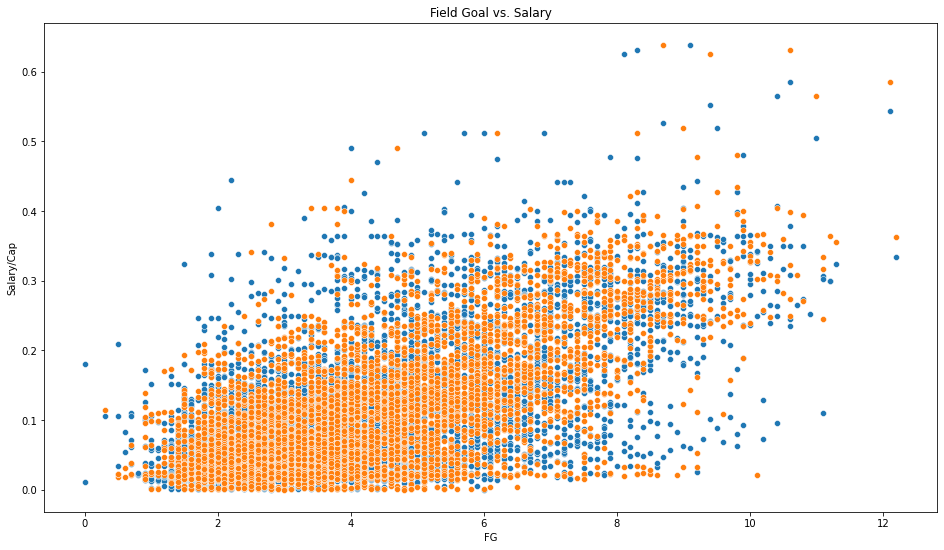

In [368]:
%matplotlib inline
plt.figure(figsize=(16,9))
partial_df = data_df[data_df["MP"] > 15]
sns.scatterplot(y = partial_df["Salary/Cap"], x = partial_df["FG"])
sns.scatterplot(y = partial_df["Salary/Cap_delay"], x = partial_df["FG"]).set_title("Field Goal vs. Salary")

#### It seems that there is no apparent different between salary and delayed salary, but the delayed salary has a strong linear relation with field goal. Furthermore, if we use the delayed salary, we are less likely to over or underestimate the salary.

## Modeling

# It make more sense to use R for this part.

In [389]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [395]:
data_df = pd.read_csv("../data/clean_data/data.csv")

In [397]:
# Clean the data
clean_data = data_df[good_stats+efficiency_stats+["Salary/Cap"]].copy(deep=True)
clean_data.dropna(inplace=True)

# Train test split
x = clean_data[good_stats+efficiency_stats]
y = clean_data["Salary/Cap"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 1234)

In [392]:
model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.4420179409282162